In [ ]:
import pandas as pd
import numpy as np
import math

from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt



# INTRO

El análisis discriminante lineal (LDA) se utiliza habitualmente como técnica de reducción de la dimensionalidad en el paso de preprocesamiento para la clasificación de patrones y las aplicaciones de aprendizaje automático. El objetivo es proyectar un conjunto de datos en un espacio de menor dimensión con buena separabilidad de clases para evitar el sobreajuste ("maldición de la dimensionalidad") y también reducir los costes computacionales.

El enfoque general del LDA es muy similar a un Análisis de Componentes Principales, pero además de encontrar los ejes de componentes que maximizan la varianza de nuestros datos (PCA), estamos interesados adicionalmente en los ejes que maximizan la separación entre múltiples clases (LDA).

Así que, en pocas palabras, a menudo el objetivo de un LDA es proyectar un espacio de características (un conjunto de datos de muestras n-dimensionales) en un subespacio más pequeño k (donde k≤n-1) mientras se mantiene la información de discriminación de clases.
En general, la reducción de la dimensionalidad no sólo ayuda a reducir los costes computacionales para una tarea de clasificación determinada, sino que también puede ser útil para evitar el sobreajuste minimizando el error en la estimación de los parámetros ("maldición de la dimensionalidad").


# Resumen del enfoque LDA en 5 pasos

A continuación se enumeran los 5 pasos generales para realizar un análisis discriminante lineal; los exploraremos con más detalle en las siguientes secciones:

1. Calcular los vectores medios d-dimensionales para las diferentes clases del conjunto de datos.
2. Calcular las matrices de dispersión (matriz de dispersión entre clases y dentro de clases).
3. Calcular los vectores propios (ee1,ee2,...,eed) y los correspondientes valores propios (λλ1,λλ2,...,λλd) de las matrices de dispersión.
4. Seleccionar discriminadores lineales para el nuevo subespacio de características
5. Utilice esta matriz de d×k eigenvectores para transformar las muestras en el nuevo subespacio. Esto se puede resumir con la multiplicación de matrices YY=XX×WW (donde XX es una matriz n×dimensional que representa las n muestras, e yy son las muestras transformadas n×k-dimensionales en el nuevo subespacio).


# Preparación del conjunto de datos de muestra

## Sobre el conjunto de datos Iris

Para el siguiente tutorial, trabajaremos con el famoso conjunto de datos "Iris" que ha sido depositado en el repositorio de aprendizaje automático de la UCI
(https://archive.ics.uci.edu/ml/datasets/Iris).

El conjunto de datos de iris contiene mediciones de 150 flores de iris de tres especies diferentes.

Las tres clases del conjunto de datos de Iris:

Iris-setosa (n=50)
Iris-versicolor (n=50)
Iris-virginica (n=50)

Las cuatro características del conjunto de datos de Iris:

longitud del sépalo en cm
anchura del sépalo en cm
longitud de los pétalos en cm
anchura de los pétalos en cm

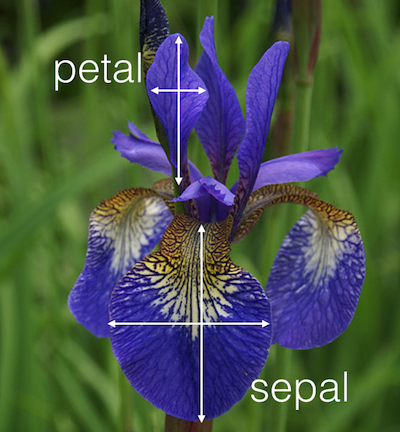

## Carga de datos

In [ ]:
# Create a dictionary with the features names
feature_dict = {i:label for i,label in zip(
                range(4),
                  ('sepal length in cm',
                  'sepal width in cm',
                  'petal length in cm',
                  'petal width in cm', ))}


#Read the data
df = pd.io.parsers.read_csv(
    filepath_or_buffer='https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',
    header=None,
    sep=',',
    )
df.columns = [l for i,l in sorted(feature_dict.items())] + ['class label']
df.dropna(how="all", inplace=True) # to drop the empty line at file-end

df.head()

,sepal length in cm,sepal width in cm,petal length in cm,petal width in cm,class label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


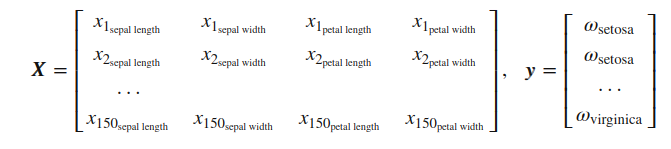

Como es más conveniente trabajar con valores numéricos, utilizaremos el LabelEncoder de la biblioteca scikit-learn para convertir las etiquetas de las clases en números: 1, 2 y 3.

In [ ]:
X = df.iloc[:,[0,1,2,3]].values
y = df['class label'].values

enc = LabelEncoder()
label_encoder = enc.fit(y)
y = label_encoder.transform(y) + 1

label_dict = {1: 'Setosa', 2: 'Versicolor', 3:'Virginica'}

## Histogramas y selección de características
Para tener una idea aproximada de cómo se distribuyen las muestras de nuestras tres clases ω1, ω2 y ω3, vamos a visualizar las distribuciones de las cuatro características diferentes en histogramas unidimensionales.

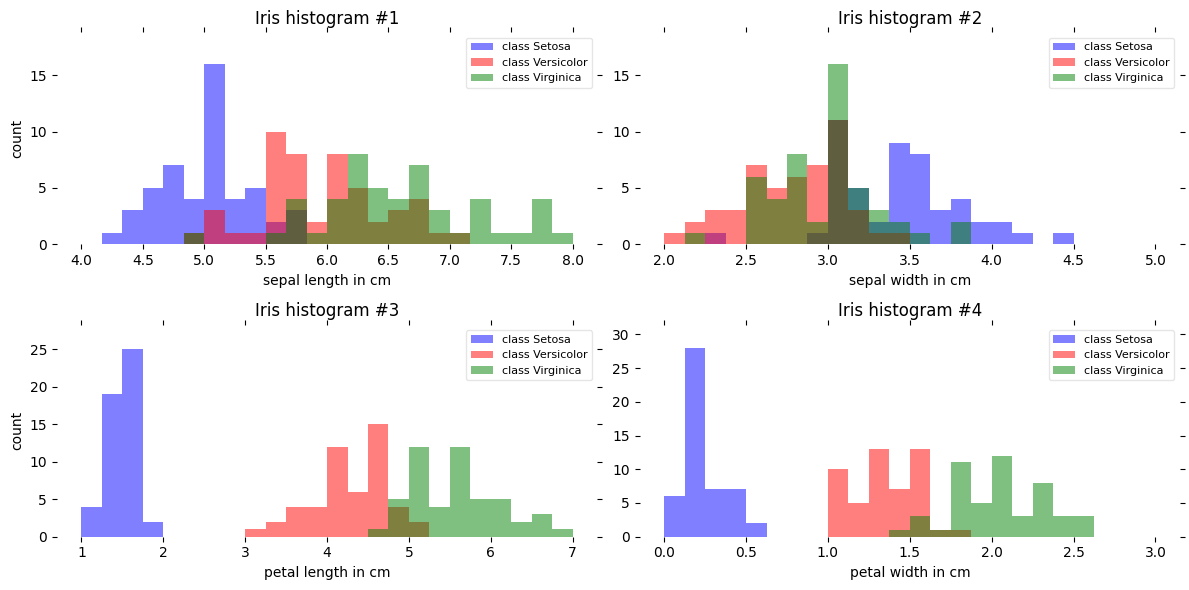

In [ ]:
%matplotlib inline

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,6))

for ax,cnt in zip(axes.ravel(), range(4)):

    # set bin sizes
    min_b = math.floor(np.min(X[:,cnt]))
    max_b = math.ceil(np.max(X[:,cnt]))
    bins = np.linspace(min_b, max_b, 25)

    # plottling the histograms
    for lab,col in zip(range(1,4), ('blue', 'red', 'green')):
        ax.hist(X[y==lab, cnt],
                   color=col,
                   label='class %s' %label_dict[lab],
                   bins=bins,
                   alpha=0.5,)
    ylims = ax.get_ylim()

    # plot annotation
    leg = ax.legend(loc='upper right', fancybox=True, fontsize=8)
    leg.get_frame().set_alpha(0.5)
    ax.set_ylim([0, max(ylims)+2])
    ax.set_xlabel(feature_dict[cnt])
    ax.set_title('Iris histogram #%s' %str(cnt+1))

    # hide axis ticks
    ax.tick_params(axis="both", which="both", bottom="off", top="off",
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)

axes[0][0].set_ylabel('count')
axes[1][0].set_ylabel('count')

fig.tight_layout()

plt.show()

Con sólo mirar estas simples representaciones gráficas de las características, ya podemos decir que las longitudes y anchuras de los pétalos son probablemente más adecuadas como características potenciales dos separar entre las tres clases de flores. En la práctica, en lugar de reducir la dimensionalidad mediante una proyección (aquí: LDA), una buena alternativa sería una técnica de selección de características. Para conjuntos de datos de baja dimensión como Iris, un vistazo a esos histogramas ya sería muy informativo. Otra técnica simple, pero muy útil, sería utilizar algoritmos de selección de características; una descripción más detallada de los algoritmos de selección de características secuenciales de la librería [MLxtend](http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/), y scikit-learn también implementa una buena selección de [enfoques alternativos](https://scikit-learn.org/stable/modules/feature_selection.html). Para un resumen de alto nivel de los diferentes enfoques, este post  [“What is the difference between filter, wrapper, and embedded methods for feature selection?”](https://sebastianraschka.com/faq/docs/feature_sele_categories.html).

## Supuestos de normalidad
Hay que mencionar que el LDA asume que los datos tienen una distribución normal, que las características son estadísticamente independientes (iid) y que las matrices de covarianza son idénticas para cada clase. Sin embargo, esto sólo se aplica al LDA como clasificador y el LDA para la reducción de la dimensionalidad también puede funcionar razonablemente bien si se violan esos supuestos. E incluso para tareas de clasificación, LDA parece ser bastante robusto a la distribución de los datos:

*“linear discriminant analysis frequently achieves good performances in the tasks of face and object recognition, even though the assumptions of common covariance matrix among groups and normality are often violated (Duda, et al., 2001)” (Tao Li, et al., 2006).*


# LDA en 5 pasos

Después de pasar por varios pasos de preparación, nuestros datos están finalmente listos para el LDA real. En la práctica, el LDA para la reducción de la dimensionalidad sería un paso más de preprocesamiento para una tarea típica de aprendizaje automático o de clasificación de patrones.




## Paso 1: Cálculo de los vectores medios d-dimensionales
En este primer paso, empezaremos con un simple cálculo de los vectores medios m_{i}, (i=1,2,3) de las 3 clases diferentes de flores:

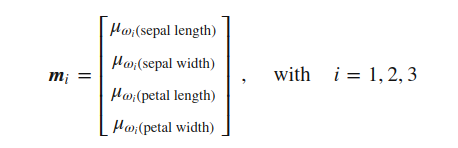

In [ ]:
np.set_printoptions(precision=4)

mean_vectors = []
for cl in range(1,4):
    mean_vectors.append(np.mean(X[y==cl], axis=0))
    print('Mean Vector class %s: %s\n' %(cl, mean_vectors[cl-1]))

Mean Vector class 1: [5.006 3.418 1.464 0.244]

Mean Vector class 2: [5.936 2.77  4.26  1.326]

Mean Vector class 3: [6.588 2.974 5.552 2.026]



## 2. Calcular las matrices de dispersión

Ahora calculamos la dos matrices de dimensiones 4x4. La matriz de dispersión within-class y la matriz de dispersión between-class.

### 2.1 Within-class scatter matrix (Sw)

Se calcula de la siguiente forma:

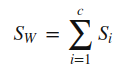

donde

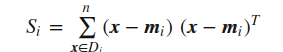

y mi es el vector de medias:

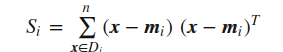

In [ ]:
S_W = np.zeros((4,4))
for cl,mv in zip(range(1,4), mean_vectors):
    class_sc_mat = np.zeros((4,4))                  # scatter matrix for every class
    for row in X[y == cl]:
        row, mv = row.reshape(4,1), mv.reshape(4,1) # make column vectors
        class_sc_mat += (row-mv).dot((row-mv).T)
    S_W += class_sc_mat                             # sum class scatter matrices
print('within-class Scatter Matrix:\n', S_W)

within-class Scatter Matrix:
 [[38.9562 13.683  24.614   5.6556]
 [13.683  17.035   8.12    4.9132]
 [24.614   8.12   27.22    6.2536]
 [ 5.6556  4.9132  6.2536  6.1756]]


### 2.2. Matriz de dispersión Betwee-class (Sb)

La matriz de dispersión se calcula de la siguiente forma:

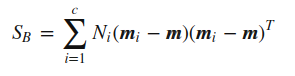

donde m es la media global, y mi y Ni son la media muestral y el tamaño de cada clase

In [ ]:
overall_mean = np.mean(X, axis=0)

S_B = np.zeros((4,4))
for i,mean_vec in enumerate(mean_vectors):
    n = X[y==i+1,:].shape[0]
    mean_vec = mean_vec.reshape(4,1) # make column vector
    overall_mean = overall_mean.reshape(4,1) # make column vector
    S_B += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)

print('between-class Scatter Matrix:\n', S_B)

between-class Scatter Matrix:
 [[ 63.2121 -19.534  165.1647  71.3631]
 [-19.534   10.9776 -56.0552 -22.4924]
 [165.1647 -56.0552 436.6437 186.9081]
 [ 71.3631 -22.4924 186.9081  80.6041]]


## 3. Calcular los eigenvectors y los eigenvalues de las matrices de dispersión.


Ahora calculamos los eigenvalues y los eigenvectores de la matriz:
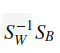

In [ ]:
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

for i in range(len(eig_vals)):
    eigvec_sc = eig_vecs[:,i].reshape(4,1)
    print('\nEigenvector {}: \n{}'.format(i+1, eigvec_sc.real))
    print('Eigenvalue {:}: {:.2e}'.format(i+1, eig_vals[i].real))


Eigenvector 1: 
[[-0.2049]
 [-0.3871]
 [ 0.5465]
 [ 0.7138]]
Eigenvalue 1: 3.23e+01

Eigenvector 2: 
[[-0.009 ]
 [-0.589 ]
 [ 0.2543]
 [-0.767 ]]
Eigenvalue 2: 2.78e-01

Eigenvector 3: 
[[ 0.0249]
 [ 0.2771]
 [ 0.3365]
 [-0.725 ]]
Eigenvalue 3: 1.95e-15

Eigenvector 4: 
[[ 0.0249]
 [ 0.2771]
 [ 0.3365]
 [-0.725 ]]
Eigenvalue 4: 1.95e-15


Después de esta descomposición de nuestra matriz cuadrada en eigenvectores y valores propios, recapitulemos brevemente cómo podemos interpretar esos resultados. Tanto los vectores propios como los valores propios nos proporcionan información sobre la distorsión de una transformación lineal: Los eigenvectores son básicamente la dirección de esta distorsión, y los eigenvalores son el factor de escala para los eigenvectores que describen la magnitud de la distorsión.

Si realizamos el LDA para la reducción de la dimensionalidad, los eigenvectores son importantes, ya que formarán los nuevos ejes de nuestro nuevo subespacio de características; los eigenvalores asociados son de especial interés, ya que nos dirán cómo de "informativos" son los nuevos "ejes".

## 4. Seleccionar discriminadores lineales para el nuevo subespacio de características


## 4.1 Ordenando los eigenvectors por los eigenvalues en orden descendente

Recuerde de la introducción que no sólo estamos interesados en proyectar los datos en un subespacio que mejore la separabilidad de la clase, sino que también reduce la dimensionalidad de nuestro espacio de características, (donde los eigenvectores formarán los ejes de este nuevo subespacio de características).

Sin embargo, los eigenvectores sólo definen las direcciones del nuevo eje, ya que todos tienen la misma longitud unitaria 1.

Por lo tanto, para decidir qué eigenvector(es) queremos dejar para nuestro subespacio de dimensiones inferiores, tenemos que echar un vistazo a los correspondientes eigenvalores de los eigenvectores. A grandes rasgos, los eigenvectores con los valores propios más bajos son los que menos información aportan sobre la distribución de los datos, y esos son los que queremos descartar.
El enfoque común es ordenar los eigenvectores de mayor a menor valor propio correspondiente y elegir los k mejores eigenvectores.

In [ ]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues

print('Eigenvalues in decreasing order:\n')
for i in eig_pairs:
    print(i[0])

Eigenvalues in decreasing order:

32.271957799729805
0.2775668638400511
4.983822267957955e-15
4.983822267957955e-15


Nota

Si echamos un vistazo a los valores propios, ya podemos ver que 2 valores propios están cerca de 0. La razón por la que están cerca de 0 no es que no sean informativos, sino que se debe a la imprecisión del punto flotante. De hecho, estos dos últimos eigenvalores deberían ser exactamente cero: En LDA, el número de discriminantes lineales es como máximo c-1, donde c es el número de etiquetas de clase, ya que la matriz de dispersión SB es la suma de c matrices con rango 1 o menos. Tenga en cuenta que en el raro caso de colinealidad perfecta (todos los puntos de muestra alineados caen en una línea recta), la matriz de covarianza tendría rango uno, lo que daría lugar a un solo eigenvector con un valor propio distinto de cero.

Ahora, expresemos la "varianza explicada" como porcentaje:

In [ ]:
print('Variance explained:\n')
eigv_sum = sum(eig_vals)
for i,j in enumerate(eig_pairs):
    print('eigenvalue {0:}: {1:.2%}'.format(i+1, (j[0]/eigv_sum).real))

Variance explained:

eigenvalue 1: 99.15%
eigenvalue 2: 0.85%
eigenvalue 3: 0.00%
eigenvalue 4: 0.00%


El primer par propio es, con mucho, el más informativo, y no perderemos mucha información si formamos una característica 1D espaciada basada en este par propio.

### 4.2 Escogemos el top k eigenvectors con los mayores eigenvalues

Después de ordenar los pares propios por valores propios decrecientes, es el momento de construir nuestra matriz de eigenvectores WW de k×d dimensiones (aquí 4×2: basada en los 2 pares propios más informativos) y reducir así el espacio de características inicial de 4 dimensiones en un subespacio de características de 2 dimensiones.
El primer par propio es, con mucho, el más informativo, y no perderemos mucha información si formamos una característica 1D espaciada basada en este par propio.


## 5. Utilice esta matriz de d×k eigenvectores para transformar las muestras en el nuevo subespacio.

In [ ]:
W = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1)))
print('Matrix W:\n', W.real)

Matrix W:
 [[-0.2049 -0.009 ]
 [-0.3871 -0.589 ]
 [ 0.5465  0.2543]
 [ 0.7138 -0.767 ]]


En el último paso, utilizamos la matriz WW de 4×2 dimensiones que acabamos de calcular para transformar nuestras muestras en el nuevo subespacio mediante la ecuación:

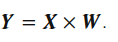

donde X es una matriz nxd que representa las n muestras e Y son las muestras transformadas en el nuevo espacio:

In [ ]:
X_lda = X.dot(W)
assert X_lda.shape == (150,2), "The matrix is not 150x2 dimensional."

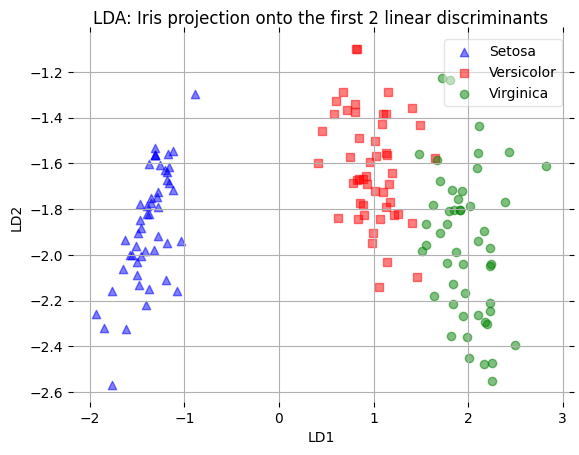

In [ ]:
from matplotlib import pyplot as plt

def plot_step_lda():

    ax = plt.subplot(111)
    for label,marker,color in zip(
        range(1,4),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X_lda[:,0].real[y == label],
                y=X_lda[:,1].real[y == label],
                marker=marker,
                color=color,
                alpha=0.5,
                label=label_dict[label]
                )

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title('LDA: Iris projection onto the first 2 linear discriminants')

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)

    plt.grid()
    plt.tight_layout
    plt.show()

plot_step_lda()

El gráfico de dispersión anterior representa nuestro nuevo subespacio de características que hemos construido mediante LDA. Podemos ver que el primer discriminante lineal "LD1" separa bastante bien las clases. Sin embargo, el segundo discriminante, "LD2", no añade mucha información valiosa, lo que ya hemos concluido cuando miramos los eigenvalores clasificados en el paso 4.
En el último paso, utilizamos la matriz WW de 4×2 dimensiones que acabamos de calcular para transformar nuestras muestras en el nuevo subespacio mediante la ecuación


# Comparación entre PCA Y LDA

Para comparar el subespacio de características que obtuvimos mediante el Análisis Discriminante Lineal, utilizaremos la clase PCA de la librería de aprendizaje automático scikit-learn. La documentación se puede encontrar aquí:
http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html.

Para nuestra comodidad, podemos especificar directamente cuántos componentes queremos retener en nuestro conjunto de datos de entrada a través del parámetro n_componentes

Pero antes de pasar a los resultados de las respectivas transformaciones lineales, recapitulemos rápidamente los propósitos de PCA y LDA: PCA encuentra los ejes con la máxima varianza para todo el conjunto de datos, mientras que LDA trata de encontrar los ejes para la mejor separación de clases. En la práctica, a menudo se realiza un LDA seguido de un PCA para reducir la dimensionalidad.

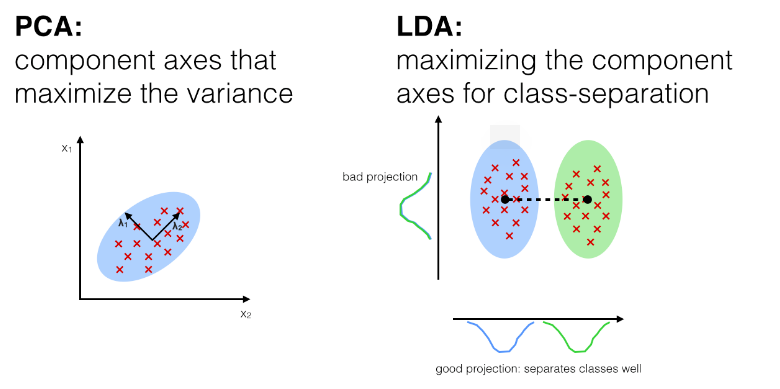


In [ ]:
from sklearn.decomposition import PCA as sklearnPCA

sklearn_pca = sklearnPCA(n_components=2)
X_pca = sklearn_pca.fit_transform(X)

def plot_pca():

    ax = plt.subplot(111)

    for label,marker,color in zip(
        range(1,4),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X_pca[:,0][y == label],
                y=X_pca[:,1][y == label],
                marker=marker,
                color=color,
                alpha=0.5,
                label=label_dict[label]
                )

    plt.xlabel('PC1')
    plt.ylabel('PC2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title('PCA: Iris projection onto the first 2 principal components')

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)

    plt.tight_layout
    plt.grid()

    plt.show()

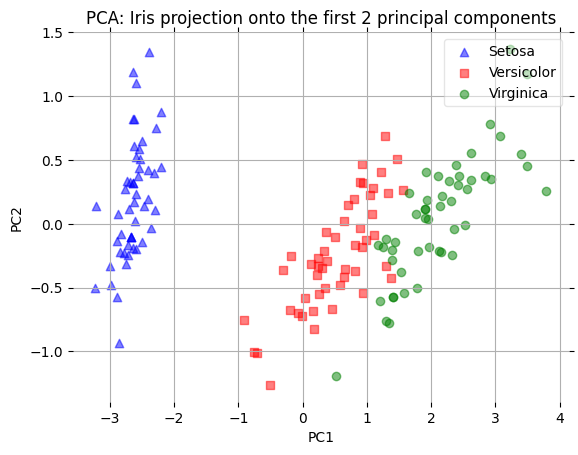

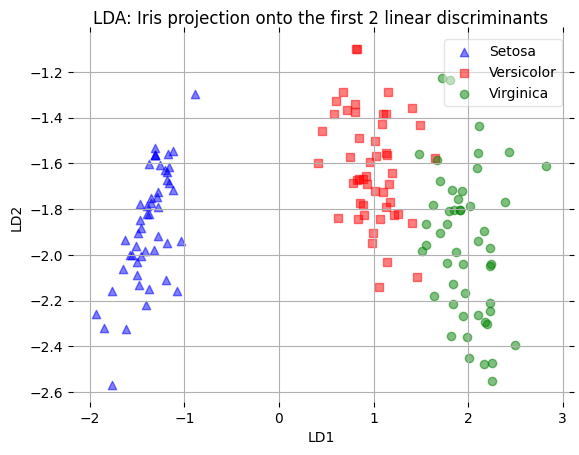

In [ ]:
plot_pca()
plot_step_lda()

Los dos gráficos anteriores confirman perfectamente lo que hemos comentado antes: Mientras que el PCA representa la mayor parte de la varianza en el conjunto de datos, el LDA nos da los ejes que representan la mayor varianza entre las clases individuales.
En el último paso, utilizamos la matriz WW de 4×2 dimensiones que acabamos de calcular para transformar nuestras muestras en el nuevo subespacio mediante la ecuación


# LDA con scikit-learn
Ahora, después de haber visto cómo funciona un Análisis Discriminante Lineal utilizando un enfoque paso a paso, también hay una manera más conveniente de lograr lo mismo a través de la clase LDA implementada en la biblioteca de scikit-learn.

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# LDA
sklearn_lda = LDA(n_components=2)
X_lda_sklearn = sklearn_lda.fit_transform(X, y)

In [ ]:
def plot_scikit_lda(X, title):

    ax = plt.subplot(111)
    for label,marker,color in zip(
        range(1,4),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X[:,0][y == label],
                    y=X[:,1][y == label] * -1, # flip the figure
                    marker=marker,
                    color=color,
                    alpha=0.5,
                    label=label_dict[label])

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title(title)

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)

    plt.grid()
    plt.tight_layout
    plt.show()

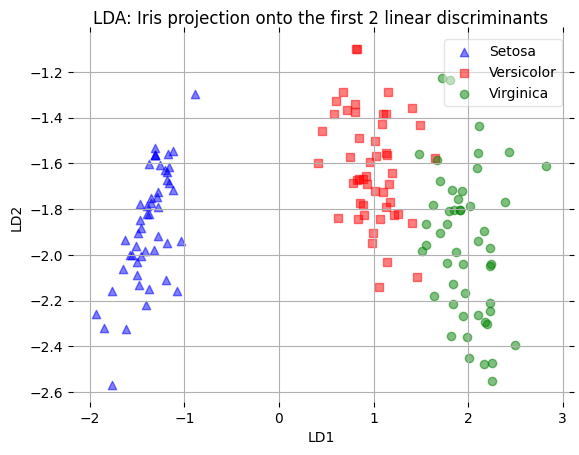

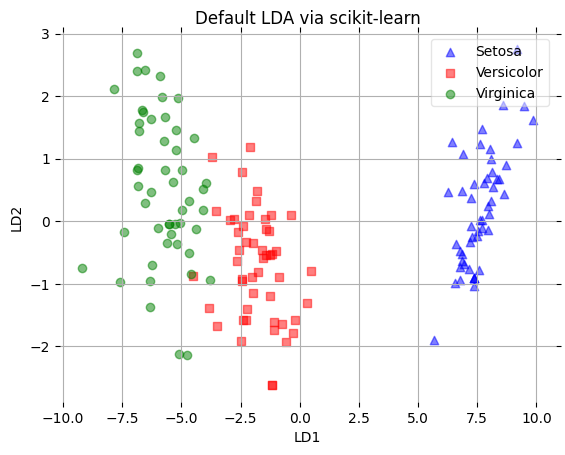

In [ ]:
plot_step_lda()
plot_scikit_lda(X_lda_sklearn, title='Default LDA via scikit-learn')